In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [ ]:
from notebook_utils.utils import *
from notebook_utils.data_generation import *
from pycss.subset_selection import *
from pycss.utils import *
from pycss.PCSS import *
from pycss.CSS import *
from pycss.model_selection import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.stats import skewcauchy
from choldate import cholupdate
import multiprocessing
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm
from pingouin import cronbach_alpha
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as n2r
import itertools

efa = rpackages.importr('EFAutilities')
n2r.activate()

: 

In [ ]:
def cov_df(p):
    return int(p*(p+1)/2)

def model_df(p, k, noise):
    if noise == 'sph':
        return cov_df(k) + (p-k)*k + 1 if k < p else cov_df(p)
    if noise == 'diag':
        return cov_df(k) + (p-k)*(k+ 1)

: 

In [ ]:
p = 50
k = 20
n = 5000
B = 5000

#W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

#np.random.seed(0)
#W *= np.random.choice(np.array([-1, 1]), W.shape)
#W*=np.sqrt(1/8)

Ts = []


for i in tqdm(range(B)):
    X_S = np.random.normal(0, 1, (n, k))
    noise = np.random.normal(0, 1, n)
    noise = np.vstack([noise for i in range(p-k)]).T
    noise *= np.random.choice([-1, 1], size=noise.shape)
    X_S_comp =  X_S @ W.T + noise
    #X_S_comp =  X_S @ W.T + (np.random.exponential(1, (n, p-k)) - 1)
    #X_S_comp =  X_S @ W.T + np.random.uniform(-5, 5, (n, p-k))
    X = np.hstack([X_S, X_S_comp])
    _, Sigma_hat = get_moments(X)
    resid = regress_off(Sigma_hat, np.arange(k))[k:, k:]
    T = n * (np.sum(np.log(np.diag(resid))) - np.log(np.linalg.det(resid)))
    Ts.append(T)

x = np.arange(min(Ts), max(Ts), 0.001)
plt.hist(Ts, bins=100, density=True)
plt.plot(x,chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'diag')))
plt.show()

: 

In [ ]:
def sample_null(B, n, p, k):
    num_adjusted_samples = n - k # no mean removed 
    num_features = p-k
    full_dfs = np.array([num_adjusted_samples - i + 1 for i in range(1, num_features + 1)])
    full_chi_sqs = np.random.chisquare(df=full_dfs, size=(B, len(full_dfs)))
    null_dfs = np.arange(1, num_features)
    null_chi_sqs = np.random.chisquare(df=null_dfs, size=(B, len(null_dfs)))
    null_chi_sqs = np.hstack([np.zeros(B).reshape((B, 1)), null_chi_sqs])
    return n*(np.sum( np.log(null_chi_sqs/full_chi_sqs + 1), axis=1))


: 

In [ ]:
B = 10000
n=5000
p=20
k=10
stats = []
t_df=3
chi_df=3


if (p-k) % 2 == 1:
    print('p-k must be even')

X_S = np.random.uniform(-100, 100, (n, k))
H = X_S @ np.linalg.inv(X_S.T @ X_S) @ X_S.T
P = np.eye(n) - X_S @ np.linalg.inv(X_S.T @ X_S) @ X_S.T

for i in tqdm(range(B)):
    #if t_df == np.inf:
    #    E = np.random.normal(0, 1, size=(n, p-k))
    #else:
    #    E = np.random.standard_t(df=t_df, size=(n, p))
    #E1 = np.random.chisquare(chi_df, size=(n, int((p-k)/2))) - chi_df
    #E2 = np.random.standard_t(df=t_df, size=(n, int((p-k)/2)))
    #E = np.hstack([E1, E2])
    #E = np.random.choice([-1, 1], size=(n, p-k))
    E = np.random.standard_t(df=t_df, size=(n, p-k))
    M = E.T @ E
    #M = E.T @ P @ E
    stats.append( n*(np.sum(np.log(np.diag(M))) - np.log(np.linalg.det(M))) )
plt.hist(stats, bins=50, density=True, label='real', alpha=0.7)
#plt.hist(sample_null(B, n, p, k), bins=50, density=True, label='finite', alpha=0.7)

x = np.arange(min(stats), max(stats), 0.001)
plt.plot(x,chi2.pdf(x, df=int((p-k)*(p-k-1)/2)), label='limiting',alpha=0.7)
plt.legend()

: 

In [ ]:
def comp_stat(Sigma, n, k):
    resid = regress_off(Sigma, np.arange(k))
    return n * (np.sum(np.log(np.diag(resid[k:, k:]))) - np.log(np.linalg.det(resid[k:, k:])))

def sample_null(B, n, p, k):
    num_adjusted_samples = n - k - 1 
    num_features = p-k
    full_dfs = np.array([num_adjusted_samples - i + 1 for i in range(1, num_features + 1)])
    full_chi_sqs = np.random.chisquare(df=full_dfs, size=(B, len(full_dfs)))
    null_dfs = np.arange(1, num_features)
    null_chi_sqs = np.random.chisquare(df=null_dfs, size=(B, len(null_dfs)))
    null_chi_sqs = np.hstack([np.zeros(B).reshape((B, 1)), null_chi_sqs])
    return n*(np.sum( np.log(null_chi_sqs/full_chi_sqs + 1), axis=1))

k_to_color = {20: 'tab:blue',
             21: 'tab:orange',
             22: 'tab:green'}
B=1000
p=50
k=20
n=100
F_dist = 'ordinal'
eps_dist = 'nonnormal'

x = np.arange(250, 550, 0.001)

if F_dist == 'gaussian':
    X_S = np.random.normal(0, 1, (B, n, k)) @ C_chol.T[np.newaxis, :, :]
if F_dist == 'ordinal':
    X_S = np.random.choice(np.array([0, 1, 2, 3, 4]), size=(B, n, k))
if F_dist == 'cauchy':
    X_S = skewcauchy.rvs(a=0.5, size=(B, n, k))

if eps_dist=='normal':
    X = generate_PCSS_data(X_S, W, D=D)
elif eps_dist == 'nonnormal': 
    eps1 = np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1
    eps2 = np.random.chisquare(3, size=(B, n , int((p-k)/3))) - 3
    eps3 = np.random.standard_t(5, size=(B, n , int((p-k)/3)))
    eps = np.dstack([eps1, eps2, eps3])  
    X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
    X = np.dstack([X_S, X_S_comp])

X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c



for i in range(k, k+3):
    
    ## plot asymptotics
    
    plt.plot(x, chi2.pdf(x, df=int((p-i)*(p-i-1)/2)), label='k=' + str(20 + i), color=k_to_color[i], alpha=0.7)
    plt.axvline(chi2.ppf(0.9, df=int((p-i)*(p-i-1)/2)), color=k_to_color[i]) 
    
    
    ## plot finite sample
    
    target_stats = sample_null(B, n, p, i)
    plt.hist(target_stats, color=k_to_color[i], alpha=0.5, density=True, edgecolor='black')
    plt.axvline(np.quantile(target_stats, 0.9), color=k_to_color[i], linestyle='dotted')
    
    
    ## plot actual dist 
    real_stats = []
    for j in range(B):
        try:
            real_stats.append(comp_stat(Sigma_hats[j, :, :], n, i))
        except:
            pass 
    plt.hist(real_stats, color=k_to_color[i], alpha=0.5, density=True)
    plt.axvline(np.quantile(real_stats, 0.9), color=k_to_color[i], linestyle='dashed')

: 

In [ ]:
B = 100
n = 500
p=50
k=20

def comp_stat(Sigma, n, S):
    p = Sigma.shape[0]
    S_comp = complement(p, S)
    resid = regress_off(Sigma, S)
    resid_comp = resid[:, S_comp][S_comp, :]
    return n * (np.sum(np.log(np.diag(resid_comp))) - np.log(np.linalg.det(resid_comp)))

X_S = np.random.choice(np.array([0, 1, 2, 3, 4]), size=(B, n, k))

eps1 = np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1
eps2 = np.random.chisquare(3, size=(B, n , int((p-k)/3))) - 3
eps3 = np.random.standard_t(5, size=(B, n , int((p-k)/3)))
eps = np.dstack([eps1, eps2, eps3])  
X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
X = np.dstack([X_S, X_S_comp])
X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c

reject = np.zeros(B)
plotting = []

for i in range(B):
    pcss = PCSS()
    pcss.compute_MLE_from_cov(Sigma_hats[i, :, :], k=k+2, method='swap', noise='diag')
    stat = comp_stat(Sigma_hats[i, :, :], n, pcss.S)
    plotting.append(comp_stat(Sigma_hats[i, :, :], n, np.arange(k+2)))
    if stat > scipy.stats.chi2.ppf(0.9, df=int( (p - (k + 2)) * (p - (k + 2) - 1)/2)):
        reject[i] = 1

np.mean(reject)

: 

In [ ]:
nums = []
for i in range(B):
    nums.append(len(sieves_gaussian_LRT(Sigma_hats[0, :, :], n, 0.1, noise='diag', method='swap', num_inits=1, asymptotic=True)))
                              
                              
                              
                              

: 

: 

In [ ]:
comp_stat(Sigma_hats[0, :, :], n, k+i)

: 

In [ ]:
regress_off(Sigma_hats[0, :, :], np.arange(k))

: 

In [ ]:
stats

: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10 , 3 ))

p = 50
k = 20
n = 500
real_dist = sample_LRT_stat_under_null(n, p, k, B=int(1e6), noise='diag')
sns.distplot(real_dist, ax=axes[0], color='tab:blue')
x = np.arange(min(real_dist), max(real_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'diag')), ax=axes[0], color='tab:orange')

p = 50
k = 20
n = 5000
real_dist = sample_LRT_stat_under_null(n, p, k, B=int(1e6), noise='diag')
sns.distplot(real_dist, ax=axes[1], color='tab:blue')
x = np.arange(min(real_dist), max(real_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'diag')), ax=axes[1], color='tab:orange')

pivotal_handle, = plt.plot([], [], color='tab:blue', label='Finite Sample Dist.', linewidth=4)
wilks_handle, = plt.plot([], [], color='tab:orange', label='Asymptotic Dist.', linewidth=4)


leg = fig.legend(handles=[pivotal_handle, wilks_handle], prop={'size': 9}, bbox_to_anchor=(0.64, 0.02), ncol=2)  
plt.tight_layout()

#plt.savefig("../figures/dist_comparison.pdf", bbox_inches='tight')

: 

In [ ]:
from pycss.CSS import *
from pycss.subset_selection import *
from notebook_utils.utils import * 
from notebook_utils.data_generation import * 
from notebook_utils.missing_data import *


p = 25
k = 8
C_chol = get_equicorrelated_chol(k, 0.25, diag=1)
C = C_chol @ C_chol.T
sigma_sq = 0.2
    
W = get_block_W(p, k, num_blocks=2, block_size=3, overlap=2)

#signs = np.array([[1, 1, 1, 0], 
#                  [1, 1, -1, 0], 
#                  [1, -1, 1, 0], 
#                  [1, -1, -1, 0], 
#                  [-1, 1, 1, 0],
#                  [-1, 1, -1, 0], 
#                  [-1, -1, 1, 0],
#                  [-1, -1, -1, 0],
#                  [0, 1, 1, 1], 
#                  [0, 1, 1, -1], 
#                  [0, 1, -1, 1], 
#                  [0, 1, -1, -1], 
#                  [0, -1, 1, 1],
#                  [0, -1, 1, -1], 
#                  [0, -1, -1, 1],
#                  [0, -1, -1, -1]])


#W *= signs
W = np.random.choice([-1, 1], size=(p-k , k))
signal_sizes = np.sum(W * (W @ C), axis=1)
W = np.sqrt(1 - sigma_sq)/np.sqrt(signal_sizes)[:, None] * W
S = np.arange(k)

MLE = {'C_MLE': C,
       'W_MLE': W,
       'sigma_sq_MLE': sigma_sq,
       'S_MLE': np.arange(k)}


def Sigma_MLE_from_MLE(MLE):
    
    noise = noise_from_MLE(MLE)
    p = np.sum(MLE['W_MLE'].shape)
    k = len(MLE['S_MLE'])
    
    Sigma_MLE = np.zeros((p, p))
    Sigma_MLE[:k, :k] = MLE['C_MLE'].copy()
    Sigma_MLE[k:, :k] = MLE['W_MLE'] @ MLE['C_MLE']
    Sigma_MLE[:k, k:] = Sigma_MLE[k:, :k].T.copy()
    Sigma_MLE[k:, k:] =  MLE['W_MLE'] @ MLE['C_MLE'] @ MLE['W_MLE'].T
    if noise == 'sph':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['sigma_sq_MLE'])
    if noise == 'diag':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['D_MLE'])
    perm_in_place(Sigma_MLE, np.concatenate([MLE['S_MLE'], complement(p, MLE['S_MLE'])]), np.arange(p))
    
    return Sigma_MLE
    

Sigma = Sigma_MLE_from_MLE(MLE)


: 

In [ ]:
import itertools

sets = []
vals = []

for s in tqdm(itertools.combinations(np.arange(p), k)):
    sets.append(s)
    comp = complement(p, s)
    resid = Sigma[comp, :][:, comp] - Sigma[comp, :][:, s] @ np.linalg.inv(Sigma[s, :][:, s]) @ Sigma[s, :][:, comp]
    vals.append(np.log(np.linalg.det(Sigma[:, s][s, :])) + np.sum(np.log(np.diag(resid))))

sorting = np.argsort(vals)
S_first = sets[sorting[0]]
S_second = sets[sorting[1]]
print(sets[sorting[0]])
print(sets[sorting[1]])

: 

In [ ]:
n = 26
B = 1000
thresh = Q(0.99, n, p, k, noise='diag')
Sigma_chol = np.linalg.cholesky(Sigma)
X = np.random.normal(0, 1, (B, n, p)) @ Sigma_chol.T[np.newaxis, :, :]
X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
first_reject = []
second_reject = []
for i in range(B):
    resid_1 = regress_off(Sigma_hats[i, :, :], S_first)[:, complement(p, S_first)][complement(p, S_first), :]
    resid_2 = regress_off(Sigma_hats[i, :, :], S_second)[complement(p, S_second), : ][:,  complement(p, S_second) ]
    stat_1 = n * (np.sum(np.log(np.diag(resid_1))) - np.log(np.linalg.det(resid_1)))
    stat_2 = n * (np.sum(np.log(np.diag(resid_2))) - np.log(np.linalg.det(resid_2)))
    first_reject.append(stat_1 > thresh)
    second_reject.append(stat_2 > thresh)
print(np.mean(first_reject))
print(np.mean(second_reject))

: 

In [ ]:
ORDINAL_VALS = np.array([1, 2, 3, 4, 5])
ORDINAL_MEAN = np.mean(ORDINAL_VALS)
ORDINAL_VAR = np.mean([(x - ORDINAL_MEAN)**2 for x in ORDINAL_VALS]) 


def generate_ordinal_X_S(B, n, k, C_chol):
    X_S = np.random.normal(0, 1, size=(B, n, k)) @ C_chol.T[np.newaxis, :, :]
    p_vals = scipy.stats.norm().cdf(X_S)
    
    for i in range(5):
        X_S[(i*0.2 <= p_vals) & (p_vals <= (i + 1)*0.2)]= i + 1
    
    return (X_S - ORDINAL_MEAN) * 1/np.sqrt(ORDINAL_VAR)

: 

In [ ]:
def generate_t_sq_X_S(B, n, k, df=5):
    t_second = df/(df - 2)
    t_fourth = 1/(np.sqrt(np.pi) * scipy.special.gamma(df/2)) * scipy.special.gamma(5/2) * scipy.special.gamma((df - 4)/2) * df**(2)
    var = t_fourth - t_second**2
    X_S = np.square(np.random.standard_t(df, size=(B, n, k)))
    return (X_S - t_second)/np.sqrt(var)

: 

In [ ]:
df=5
1/(np.sqrt(np.pi) * scipy.special.gamma(5/2)) * scipy.special.gamma(5/2) * scipy.special.gamma(1/2) * 5**(2)

: 

In [ ]:
1/(np.sqrt(np.pi) * scipy.special.gamma(df/2)) * scipy.special.gamma(5/2) * scipy.special.gamma((df - 4)/2) * df**(2)

: 

In [ ]:
5/3

: 

In [ ]:
np.mean(np.random.standard_t(5, int(1e8)) ** 4)

: 

In [ ]:
x = generate_t_sq_X_S(1, 10000000, k, df=5)[0, :, :]
mu, Sigma = get_moments(x)
print(mu)
print(np.diag(Sigma))

: 

In [ ]:
def Sigma_MLE_from_MLE(MLE):
    
    noise = noise_from_MLE(MLE)
    p = np.sum(MLE['W_MLE'].shape)
    k = len(MLE['S_MLE'])
    
    Sigma_MLE = np.zeros((p, p))
    Sigma_MLE[:k, :k] = MLE['C_MLE'].copy()
    Sigma_MLE[k:, :k] = MLE['W_MLE'] @ MLE['C_MLE']
    Sigma_MLE[:k, k:] = Sigma_MLE[k:, :k].T.copy()
    Sigma_MLE[k:, k:] =  MLE['W_MLE'] @ MLE['C_MLE'] @ MLE['W_MLE'].T
    if noise == 'sph':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['sigma_sq_MLE'])
    if noise == 'diag':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['D_MLE'])
    perm_in_place(Sigma_MLE, np.concatenate([MLE['S_MLE'], complement(p, MLE['S_MLE'])]), np.arange(p))
    
    return Sigma_MLE

: 

In [ ]:
p = 50
k = 20
rho = 0.5
C_chol = scipy.linalg.block_diag(get_equicorrelated_chol(4, rho, diag=1), 
                        get_equicorrelated_chol(4, rho, diag=1),
                        get_equicorrelated_chol(4, rho, diag=1),
                        get_equicorrelated_chol(4, rho, diag=1),
                        get_equicorrelated_chol(4, rho, diag=1))
C = C_chol @ C_chol.T

W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

np.random.seed(0)
W *= np.random.choice(np.array([-1, 1]), W.shape)

D = np.concatenate([np.arange(1, 7) for i in range(5)] )


B = 100
noise = 'diag'
method = 'swap'
num_inits = 10 
noise_levels = [0.022, 0.81, 2.71, 9.2, 350]
noise_levels = [0.81, 2.71, 9.2]
ns = [200]
alpha = 0.05

gaussian_noise = True
asymptotic=True

signal_to_Sigma = {np.mean(np.diag(W @ C @ W.T)/(np.diag(W @ C @ W.T) + noise_level*D)): 
                   Sigma_MLE_from_MLE(MLE = {'S_MLE': np.arange(k),
                                             'C_MLE': C,
                                             'W_MLE': W,
                                             'D_MLE': noise_level * D}) 
                   for noise_level in noise_levels }

quantiles = {}

for n in ns:
    for i in range(1, p-1):
        quantiles[(n, p, i, 1 - alpha, noise)] = Q(1 - alpha, n, p, i, noise=noise)

: 

In [ ]:
X_S = np.random.normal(0, 1, (B, n, k)) @ C_chol.T[np.newaxis, :, :]
eps1 = (np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1) 
eps2 = np.random.choice([-1, 1], size=(B, n, int((p-k)/3)))
eps3 = np.random.standard_t(3, size=(B, n , int((p-k)/3))) / np.sqrt(3)
eps = np.dstack([eps1, eps2, eps3]) * np.sqrt(D)[np.newaxis, np.newaxis, : ]
#np.random.seed(0)
#eps = eps[:, :, np.random.choice(np.arange(p-k), p-k, replace=False)]
X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
X = np.dstack([X_S, X_S_comp])
X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c

: 

In [ ]:
gaussian_Sigma_hats = generate_gaussian_PCSS_sample_cov(ns[0], C_chol, W, D=D, B=B)

: 

In [ ]:
correct = []
for i in range(B):
    pcss = PCSS()
    pcss.compute_MLE_from_cov(gaussian_Sigma_hats[i, :, :], k, method='swap', noise=noise)
    correct.append(set(pcss.S).issuperset(set(np.arange(k))))
print(np.mean(correct))

: 

In [ ]:
contains = []
lengths = []
for i in tqdm(range(B)):
    selected_S = sieves_gaussian_LRT(gaussian_Sigma_hats[i, : , :], ns[0], 0.1, noise='diag', method='swap', num_inits=1, quantiles=quantiles)
    contains.append(set(selected_S).issuperset(set(np.arange(k))))
    lengths.append(len(selected_S))
print(np.mean(contains))
plt.hist(lengths)

: 

In [ ]:
def comp_stat(Sigma, n, k):
    resid = regress_off(Sigma, np.arange(k))
    return n * (np.sum(np.log(np.diag(resid[k:, k:]))) - np.log(np.linalg.det(resid[k:, k:])))

: 

In [ ]:
n = ns[0]
X_S = np.random.normal(0, 1, (B, n, k)) @ C_chol.T[np.newaxis, :, :]
eps1 = np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1
eps2 = np.random.chisquare(3, size=(B, n , int((p-k)/3))) - 3
eps3 = np.random.standard_t(5, size=(B, n , int((p-k)/3)))
eps = np.dstack([eps1, eps2, eps3])
X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
X = np.dstack([X_S, X_S_comp])
X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c

: 

In [ ]:
np.random.normal(0, 1, (B, n, k)).shape

: 

In [ ]:
stats = []
for i in range(B):
    stats.append(comp_stat(Sigma_hats[i, :, :], n, k))
    
plt.hist(stats, label='stats', color='tab:orange', alpha=0.5, density=True)
x = np.arange(min(stats), max(stats), 0.001)
plt.plot(x, chi2.pdf(x, df=int((p-k)*(p-k-1)/2)), label='chi_sq', color='tab:blue', alpha=0.5, linewidth=4)
plt.show()
print(np.mean(np.array(stats) > chi2.ppf(0.9, (p-k)*(p-k-1)/2)))

: 

In [ ]:
def get_df_from_frames(results_frames):
    
    results_df = pd.DataFrame(results_frames)
    results_df['Type I Error'] = (results_df['Size Selected'] > k).astype(int)
    results_df['% Correct'] = (results_df['Size Selected'] == k).astype(int)
    results_df['Avg. Over'] = results_df['Size Selected'] - k
    results_df.loc[results_df['Avg. Over'] <= 0, 'Avg. Over'] = np.nan
    results_df['Avg. Under'] = k - results_df['Size Selected'] 
    results_df.loc[results_df['Avg. Under'] <= 0, 'Avg. Under'] = np.nan
    
    return results_df 

def cannonical_correlation(Sigma, S1, S2):
    return np.trace(Sigma[S1, :][:, S2] @ np.linalg.inv(Sigma[S2, :][:, S2]) @ Sigma[S2, :][:, S1] @ np.linalg.inv(Sigma[S1, :][:, S1]))  

def get_df_from_frames(results_frames, k, signal_to_Sigma):
    pop_S = np.arange(k)
    results_df = pd.DataFrame(results_frames)
    results_df['Size of Selected Subset'] = [len(S) for S in results_df['Selected']]
    results_df['# Correct Variables Selected'] = [len(set(S).intersection(set(pop_S))) for S in results_df['Selected']]
    results_df['Sum of Sq. Cannonical Correlations'] = [cannonical_correlation(signal_to_Sigma[results_df['Signal Size'][i]], pop_S, results_df['Selected'][i]) for i in range(len(results_df))]
    return results_df

: 

$X_S$ is Gaussian

In [ ]:
gaussian_results_frames = {'Signal Size': [], 'Sample Size' : [], 'Selected': []}

for noise_level, n in tqdm(list(itertools.product(*[noise_levels, ns]))):
    gaussian_results_frames['Signal Size'] += list(np.mean(np.diag(W @ C @ W.T)/(np.diag(W @ C @ W.T) + noise_level*D)) * np.ones(B))
    gaussian_results_frames['Sample Size'] += list(n * np.ones(B))
    
    #Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=noise_level*D, B=B)
    
    X_S = np.random.normal(0, 1, (B, n, k)) @ C_chol.T[np.newaxis, :, :]
    eps1 = (np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1) 
    eps2 = np.random.choice([-1, 1], size=(B, n, int((p-k)/3)))
    eps3 = np.random.standard_t(3, size=(B, n , int((p-k)/3))) / np.sqrt(3)
    eps = np.dstack([eps1, eps2, eps3]) * np.sqrt(noise_level * D)[np.newaxis, np.newaxis, : ]
    X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
    X = np.dstack([X_S, X_S_comp])
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    
    mp_func = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles, asymptotic=asymptotic)
    with Pool(multiprocessing.cpu_count()) as pool:
        gaussian_results_frames['Selected'] +=  list(tqdm(pool.imap_unordered(mp_func, list(Sigma_hats))))
    
gaussian_results_df = get_df_from_frames(gaussian_results_frames, k, signal_to_Sigma)


: 

In [ ]:
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

df = gaussian_results_df.copy()
df['Signal Size'] = np.round(df['Signal Size'], 2)
df = df.loc[df['Signal Size'].isin([0.25, 0.5, 0.75])]
df = df.loc[df['Sample Size'].isin([200])]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
spacing=5
signal_spacing = 0.7  # Width of each box plot

ys = ['Size of Selected Subset', '# Correct Variables Selected', 'Sum of Sq. Cannonical Correlations']  # Replace with your desired y variable names

signal_sizes = sorted(df['Signal Size'].unique())  # Get unique signal sizes in ascending order
color_palette = sns.color_palette('Set1', n_colors=len(signal_sizes))  # Generate a color palette with distinct colors

sample_sizes = sorted(df['Sample Size'].unique())  # Get unique sample sizes in ascending order

y_min = np.min(df[ys]) - 1
y_max = np.max(df[ys]) + 1

for i, (y_var, ax) in enumerate(zip(ys, axes)):
    ax.set_title(y_var, fontsize=22)  # Set the title for each subplot
    for j, signal_size in enumerate(signal_sizes):
        subset = df[(df['Signal Size'] == signal_size)]
        color = color_palette[j]
        
        x_values = spacing*np.arange(len(sample_sizes)) + (j - len(signal_sizes) // 2) * signal_spacing # Calculate the x-values for the box plots

        for l, sample_size in enumerate(sample_sizes):
            subset_sample = subset[subset['Sample Size'] == sample_size]
            ax.set_ylim([y_min, y_max])
            ax.tick_params(axis='y', labelsize=16)
            ax.boxplot(subset_sample[y_var], 
                       positions=[x_values[l]], 
                       patch_artist=True, 
                       widths=0.4,
                       boxprops=dict(facecolor=color,
                                    alpha=0.8),
                       medianprops=dict(color='black'),
                       flierprops={'marker': 'D', 
                                   'markerfacecolor': color, 
                                   'markersize': 6,
                                   'alpha': 0.8})

        
    ax.axhline(y=20, color='black', linestyle='--')  # Add a horizontal line at y=20
    ax.set_xticks(spacing*np.arange(len(sample_sizes)))  # Set the x-axis tick positions
    ax.set_xticklabels([])  # Set the x-axis tick labels

handles = []
labels = []
for j, s in enumerate(signal_sizes):
    # Create your plot elements and store the handles and labels
    handle = Line2D([], [], marker='s', linestyle='None', markersize=15,
                    markeredgecolor='black', color=color_palette[j])
    handles.append(handle)
    labels.append('Avg. R^2=' + str(s))

handler_map = {mpatches.Patch: HandlerPatch(patch_func=lambda orig_handle, _: orig_handle)}
fig.legend(handles=handles, labels=labels, handler_map=handler_map, prop={'size': 20}, bbox_to_anchor=(0.8, 0.00), ncols=len(signal_sizes))
plt.tight_layout()
plt.show()

: 

In [ ]:
for j, signal_size in enumerate(signal_sizes):
        subset = df[(df['Signal Size'] == signal_size)]
        print(np.mean(subset['Size of Selected Subset'] > 20))

: 

In [ ]:
(np.arange(3) - len(signal_sizes) // 2)

: 

In [ ]:
np.arange(len(sample_sizes)) + (j - len(signal_sizes) // 2)

: 

In [ ]:
sns.boxplot(positions=[1],y=subset_sample[y_var], color=color, flierprops={'marker': 'D', 'markerfacecolor': color, 'markersize': 6})


: 

In [ ]:
plt.boxplot(np.random.normal(0,1, 100), positions=[15])


: 

In [ ]:
df = gaussian_results_df.copy()
df['Signal Size'] = np.round(df['Signal Size'], 2)
df = df.loc[df['Signal Size'].isin([0.25, 0.5, 0.75])]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ys = ['Size Selected', 'Intersection', 'Cannonical Correlation']  # Replace with your desired y variable names

signal_sizes = sorted(df['Signal Size'].unique())  # Get unique signal sizes in ascending order
color_palette = sns.color_palette('Set1', n_colors=len(signal_sizes))  # Generate a color palette with distinct colors

for i, (y_var, ax) in enumerate(zip(ys, axes)):
    ax.set_title(y_var)  # Set the title for each subplot
    for j, signal_size in enumerate(signal_sizes):
        subset = df[(df['Signal Size'] == signal_size) ]
        color = color_palette[j]
        sns.boxplot(x='Sample Size', y=y_var, data=subset, ax=ax, color=color, flierprops={'marker': 'D', 'markerfacecolor': color, 'markersize': 6}, boxprops=dict(alpha=.3))
        ax.axhline(y=20, color='red', linestyle='--')  # Add a horizontal line at y=20

plt.tight_layout()
plt.show()








: 

In [ ]:

df = gaussian_results_df.copy()
df['Signal Size'] = np.round(df['Signal Size'], 2)
df = df.loc[df['Signal Size'].isin([0.25, 0.5, 0.75])]
df.to_csv("for_kevin")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ys = ['Size Selected', 'Intersection', 'Cannonical Correlation']  # Replace with your desired y variable names

for i, y_var in enumerate(ys):
    ax = axes[i]
    sns.boxplot(x='Sample Size', y=y_var, hue='Signal Size', data=df, ax=ax)
    

plt.tight_layout()
plt.show()



: 

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

signal_sizes = list(set(gaussian_results_df['Signal Size']))
colors = sns.color_palette('Set1', n_colors=len(signal_sizes))
color_map = dict(zip(signal_sizes, colors))

handles = []
position = -2


for size in signal_sizes:
    # Filter the DataFrame for the current signal size
    data = gaussian_results_df[gaussian_results_df['Signal Size'] == size]
    data['Sample Size'] -= 5*position 
    print(data['Sample Size'])
    
    # Calculate the adjusted position for the current signal size
    adjusted_position = position - (offset * (len(signal_sizes) - 1) / 2)
    
    # Create the violin plot with the appropriate color and adjusted position
    violin = sns.violinplot(x='Sample Size', y='Size Selected', data=data, ax=ax, label=f"Signal Size: {np.round(size, 2)}", color=color_map[size], position=adjusted_position)
    
    # Add the violin plot handle to the handles list
    handles.append(mpatches.Patch(color=color_map[size], label=f"Signal Size: {np.round(size, 2)}"))
    
    position += 1

ax.legend(handles=handles)

: 

$X_S$ is ordinal

In [ ]:
ordinal_results_frames = {'Sample Size' : [], 'Size Selected': []}
for i, n in tqdm(enumerate(ns)):
    ordinal_results_frames['Sample Size'] += list(n * np.ones(B)) 
    X_S = np.random.choice(np.array([0, 1, 2, 3, 4]), size=(B, n, k))
    X = generate_PCSS_data(X_S, W, D=D)
    
    #X_S = np.random.choice(np.array([0, 1, 2, 3, 4]), size=(B, n, k))
    #eps1 = np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1
    #eps2 = np.random.chisquare(3, size=(B, n , int((p-k)/3))) - 3
    #eps3 = np.random.standard_t(5, size=(B, n , int((p-k)/3)))
    #eps = np.dstack([eps1, eps2, eps3])
    #X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
    #X = np.dstack([X_S, X_S_comp])
    
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    mp_func = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles, asymptotic=asymptotic)
    with Pool(multiprocessing.cpu_count()) as pool:
        ordinal_results_frames['Size Selected'] += [len(S) for S in list(tqdm(pool.imap_unordered(mp_func, list(Sigma_hats))))]
    
ordinal_results_df = get_df_from_frames(ordinal_results_frames)

: 

$X_S$ is skew Cauchy with $a=0.5$

In [ ]:
cauchy_results_frames = {'Sample Size' : [], 'Size Selected': []}
for i, n in tqdm(enumerate(ns)):
    cauchy_results_frames['Sample Size'] += list(n * np.ones(B))
    X_S = skewcauchy.rvs(a=0.5, size=(B, n, k))
    X = generate_PCSS_data(X_S, W, D=D)
    
    #X_S = skewcauchy.rvs(a=0.5, size=(B, n, k))
    #eps1 = np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1
    #eps2 = np.random.chisquare(3, size=(B, n , int((p-k)/3))) - 3
    #eps3 = np.random.standard_t(5, size=(B, n , int((p-k)/3)))
    #eps = np.dstack([eps1, eps2, eps3])
    #X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
    #X = np.dstack([X_S, X_S_comp])
    
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    checked_colinearity = False 
    while not checked_colinearity:
        nothing_complex = True
        for j in range(B):
            if np.iscomplexobj(np.min(np.linalg.eig(Sigma_hats[j, :, :])[0])):
                #X_S = skewcauchy.rvs(a=0.5, size=(n, k))
                #X = generate_PCSS_data(X_S, W, D=D)
                
                X_S = skewcauchy.rvs(a=0.5, size=(n, k))
                eps1 = np.random.exponential(1, size=(n , int((p-k)/3))) - 1
                eps2 = np.random.chisquare(3, size=(n , int((p-k)/3))) - 3
                eps3 = np.random.standard_t(5, size=(n , int((p-k)/3)))
                eps = np.hstack([eps1, eps2, eps3])
                X_S_comp = X_S @ W.T + eps
                X = np.dstack([X_S, X_S_comp])
                
                _, Sigma_hat = get_moments(X)
                Sigma_hats[j, :, :] = Sigma_hat 
                nothing_complex = False
        if nothing_complex:
            checked_colinearity = True   
    mp_func = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles, asymptotic=asymptotic)
    with Pool(multiprocessing.cpu_count()) as pool:
        cauchy_results_frames['Size Selected'] += [len(S) for S in list(tqdm(pool.imap_unordered(mp_func, list(Sigma_hats))))]
    
cauchy_results_df = get_df_from_frames(cauchy_results_frames)

: 

In [ ]:
#import pickle
#with open('gaussian_results_df.pickle', 'wb') as f:
#     pickle.dump(gaussian_results_df, f, pickle.HIGHEST_PROTOCOL)
        
#with open('ordinal_results_df.pickle', 'wb') as f:
#     pickle.dump(ordinal_results_df, f, pickle.HIGHEST_PROTOCOL)

#with open('cauchy_results_df.pickle', 'wb') as f:
#     pickle.dump(cauchy_results_df, f, pickle.HIGHEST_PROTOCOL)

#gaussian_results_df = pd.read_pickle('gaussian_results_df.pickle')
#ordinal_results_df = pd.read_pickle('ordinal_results_df.pickle')
#cauchy_results_df = pd.read_pickle('cauchy_results_df.pickle')

#gaussian_results_df  = gaussian_results_df.rename(columns={"Excess": "Avg. Over", "Dearth": "Avg. Under", "Power": "% Correct"})
#ordinal_results_df  = ordinal_results_df.rename(columns={"Excess": "Avg. Over", "Dearth": "Avg. Under", "Power": "% Correct"})
#cauchy_results_df  = cauchy_results_df.rename(columns={"Excess": "Avg. Over", "Dearth": "Avg. Under", "Power": "% Correct"})

: 

In [ ]:
results = {'Gaussian': gaussian_results_df,
          'Ordinal': ordinal_results_df,
          'Cauchy': cauchy_results_df}

dist_to_color = {'Gaussian': 'tab:blue',
                'Ordinal': 'tab:orange',
                'Cauchy': 'tab:green'}

fig, axes = plt.subplots(1, 3, figsize=(10 , 3))

for dist in dist_to_color.keys():
    ## type I error 
    color = dist_to_color[dist]
    
        ## Power
    sns.lineplot(data=results[dist],
                 x='Sample Size', 
                 y='Type I Error', 
                 ax=axes[0], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    axes[0].axhline(alpha, ls='--', c='black', alpha=0.3)
    
    sns.lineplot(data=results[dist],
                 x='Sample Size', 
                 y='% Correct', 
                 ax=axes[1],
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
    over_df = results[dist]
    
    over_df = over_df[over_df['Avg. Over'].notnull()]
    over_df = over_df[['Sample Size', 'Avg. Over']]
    for n in ns:
        if n not in set(over_df['Sample Size']):
            over_df = pd.concat([over_df, pd.DataFrame({'Sample Size': [n], 'Avg. Over': [0]})], ignore_index=True)
    sns.lineplot(data=over_df,
                 x='Sample Size', 
                 y='Avg. Over', 
                 ax=axes[2], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
gaussian_handle, = plt.plot([], [], color='tab:blue', label='Gaussian', marker='o')
ordinal_handle, = plt.plot([], [], color='tab:orange', label='Ordinal', marker='o')
cauchy_handle, = plt.plot([], [], color='tab:green', label='Cauchy', marker='o')

leg = fig.legend(handles=[gaussian_handle, ordinal_handle, cauchy_handle], prop={'size': 9}, bbox_to_anchor=(0.68, 0.02), ncol=3)  

plt.tight_layout()
#plt.savefig("../figures/model_selection_sim.pdf", bbox_inches='tight')
#plt.savefig("../figures/temp.pdf", bbox_inches='tight')

: 

In [ ]:
plt.hist(gaussian_results_df.loc[gaussian_results_df['Sample Size'] ==500]['Size Selected'])


: 

In [ ]:
results = {'Gaussian': gaussian_results_df,
          'Ordinal': ordinal_results_df,
          'Cauchy': cauchy_results_df}

dist_to_color = {'Gaussian': 'tab:blue',
                'Ordinal': 'tab:orange',
                'Cauchy': 'tab:green'}

fig, axes = plt.subplots(1, 4, figsize=(10 , 3))

for dist in dist_to_color.keys():
    ## type I error 
    color = dist_to_color[dist]
    
        ## Power
    sns.lineplot(data=results[dist],
                 x='Sample Size', 
                 y='Type I Error', 
                 ax=axes[0], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    axes[0].axhline(alpha, ls='--', c='black', alpha=0.3)
    
    sns.lineplot(data=results[dist],
                 x='Sample Size', 
                 y='% Correct', 
                 ax=axes[1],
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
    over_df = results[dist]
    
    over_df = over_df[over_df['Avg. Over'].notnull()]
    over_df = over_df[['Sample Size', 'Avg. Over']]
    for n in ns:
        if n not in set(over_df['Sample Size']):
            over_df = pd.concat([over_df, pd.DataFrame({'Sample Size': [n], 'Avg. Over': [0]})], ignore_index=True)
    sns.lineplot(data=over_df,
                 x='Sample Size', 
                 y='Avg. Over', 
                 ax=axes[2], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
    under_df = results[dist]
    
    under_df = under_df[under_df['Avg. Under'].notnull()]
    under_df = under_df[['Sample Size', 'Avg. Under']]
    for n in ns:
        if n not in set(under_df['Sample Size']):
            under_df = pd.concat([under_df, pd.DataFrame({'Sample Size': [n], 'Avg. Under': [0]})], ignore_index=True)
    sns.lineplot(data=under_df,
                 x='Sample Size', 
                 y='Avg. Under', 
                 ax=axes[3], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
gaussian_handle, = plt.plot([], [], color='tab:blue', label='Gaussian', marker='o')
ordinal_handle, = plt.plot([], [], color='tab:orange', label='Ordinal', marker='o')
cauchy_handle, = plt.plot([], [], color='tab:green', label='Cauchy', marker='o')

leg = fig.legend(handles=[gaussian_handle, ordinal_handle, cauchy_handle], prop={'size': 9}, bbox_to_anchor=(0.68, 0.02), ncol=3)  

plt.tight_layout()
#plt.savefig("../figures/model_selection_sim.pdf", bbox_inches='tight')
#plt.savefig("../figures/temp.pdf", bbox_inches='tight')

: 

### Real Data Analysis

In [ ]:
def avg_R2(Sigma, S, standardize=True):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    S_comp = complement(p, S)
    resid_var = np.diag(Sigma_R)[S_comp]
    if standardize:
        return 1 - np.mean(np.diag(Sigma_R)[S_comp])
    else:
        var = np.diag(Sigma)[S_comp]
        return np.mean((var - resid_var)/var)

: 

In [ ]:
def css_obj_plot(X, k_max, method='greedy', standardize=True, num_inits=1, plot=False):
    
    objs = np.zeros(k_max)
    _, Sigma_hat = get_moments(X)
    
    if standardize:
        Sigma_hat = standardize_cov(Sigma_hat)
    
    css = CSS()
    if method == 'greedy':
        
        css.select_subset_from_cov(Sigma_hat, k_max, method='greedy')
        S_greedy = css.S.copy()
        
        for i in range(1, k_max+1):
            objs[i - 1] = 1 - np.mean(np.diag(regress_off(Sigma_hat, S_greedy[:i])))
            #objs[i - 1] = avg_R2(Sigma_hat, S_greedy[:i], standardize=standardize)
    
    if method == 'swap':
        for i in range(1, k_max + 1):
            best_obj = np.inf
            for j in range(num_inits):
                css.select_subset_from_cov(Sigma_hat, i, method='swap')
                potential_obj = avg_R2(Sigma_hat, css.S, standardize=standardize)
                if potential_obj < best_obj:
                    best_obj = potential_obj
            objs[i - 1] = best_obj
    
    if plot:
        plt.scatter(np.arange(1, k_max + 1), objs)
    
    plt.plot()
    
    return objs
        

: 

In [ ]:
css_obj_plot(X, p, standardize=False, plot=True)

: 

In [56]:
X = pd.read_csv("../data/BFI228.csv").values[:, 1:].astype(int)
n, p = X.shape
_, Sigma_hat = get_moments(X)
n_test = 0
n_train = n - n_test
np.random.seed(0)
train_idxs = np.random.choice(n, n_train, replace=False)
test_idxs = [i for i in range(n) if i not in train_idxs]
X_train = X[train_idxs, :]
_, Sigma_hat_train = get_moments(X_train)

(array([20.,  0.,  0.,  0.,  3.,  2.,  5.,  4.,  6.,  4.]),
 array([0.        , 0.06365251, 0.12730501, 0.19095752, 0.25461002,
        0.31826253, 0.38191503, 0.44556754, 0.50922004, 0.57287255,
        0.63652505]),
 <BarContainer object of 10 artists>)

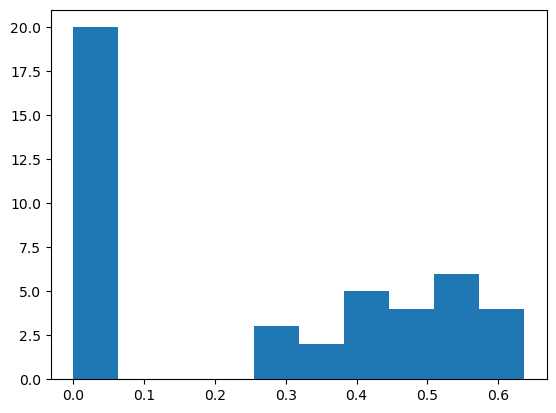

In [153]:
css = CSS()
css.select_subset_from_cov(Sigma_hat_train, k=20, method='swap')
plt.hist(np.diag(css.Sigma_R))

In [57]:
n_train

228

In [121]:
def reverse_columns(X, col_idxs, largest=5):
    for i in col_idxs:
        X[:, i] = -1*(X[:, i] - largest - 1)
    return X

cols = pd.read_csv("../data/BFI228.csv").columns[1:]
reverse_col_idxs = [i for i in range(len(cols)) if cols[i][-1] == 'R']

reversed_X = reverse_columns(X.copy(), reverse_col_idxs)
reversed_X_test = reversed_X[test_idxs, :]

BFI_IDXS = np.arange(p)
BFI_TEN_IDXS = np.sort([1, 12, 21, 27, 42, 7, 8, 17, 33, 37])
BFI_FIFTEEN_IDXS = np.sort([17, 0, 15, 34, 29, 11, 21, 7, 39, 33, 23, 1, 14, 37, 27])
BFI_PORTEGUESE_TWENTY_IDXS = np.sort([0, 7, 4, 1, 14, 11, 9, 16, 21, 20, 18, 17, 33, 28, 31, 30, 38, 34, 41, 36]) 
BFI_NORWEGIAN_TWENTY_IDXS = np.sort([0, 4, 6, 7, 9, 13, 14, 15, 17, 18, 20, 24, 26, 27, 29, 33, 34, 37, 41, 42])
BFI_ENGLISH_TWENTY_IDXS = np.sort([0, 2, 4, 7, 27, 29, 31, 30, 32, 10, 11, 14, 15, 18, 20, 21, 22, 34, 35, 38, 41])

In [122]:
def get_alphas(X, subset_idxs, ci=0.9):
    
    X_subset = X[:, subset_idxs]
    
    EXTRAVERSION_IDXS = np.arange(8)
    AGREEABLENESS_IDXS = np.arange(8, 17)
    CONSCENTIOUSNESS_IDXS = np.arange(17, 26)
    NEUROTICISM_IDXS = np.arange(26, 34)
    OPENNESS_IDXS = np.arange(34, 44)
    
    num_extraversion = len(np.intersect1d(EXTRAVERSION_IDXS, subset_idxs))
    num_agreeableness = len(np.intersect1d(AGREEABLENESS_IDXS, subset_idxs))
    num_conscentiousness = len(np.intersect1d(CONSCENTIOUSNESS_IDXS, subset_idxs))
    num_neuroticism = len(np.intersect1d(NEUROTICISM_IDXS, subset_idxs))
    num_openness = len(np.intersect1d(OPENNESS_IDXS, subset_idxs))
    
    extraversion_subset = np.arange(num_extraversion)
    agreeableness_subset = np.arange(np.max(extraversion_subset) + 1, np.max(extraversion_subset) + 1 + num_agreeableness)
    conscentiousness_subset = np.arange(np.max(agreeableness_subset) + 1, np.max(agreeableness_subset) + 1 + num_conscentiousness)
    neuroticism_subset = np.arange(np.max(conscentiousness_subset) + 1, np.max(conscentiousness_subset) + 1 + num_neuroticism)
    openness_subset = np.arange(np.max(neuroticism_subset) + 1, np.max(neuroticism_subset) + 1 + num_openness)
      
    alpha_dict = {'extraversion': cronbach_alpha(pd.DataFrame(X[:, extraversion_subset])),
                  'agreeableness': cronbach_alpha(pd.DataFrame(X[:, agreeableness_subset])),
                  'conscentiousness': cronbach_alpha(pd.DataFrame(X[:, conscentiousness_subset])),
                  'neuroticism': cronbach_alpha(pd.DataFrame(X[:, neuroticism_subset])),
                  'openness': cronbach_alpha(pd.DataFrame(X[:, openness_subset]))}
    
    return alpha_dict 

In [64]:
alpha=0.1
S = np.sort(sieves_gaussian_LRT(Sigma_hat_train, n_train, alpha, noise='diag', num_inits=100, asymptotic=False))
#css = CSS()
#min_obj = np.inf
#S = np.nan
#for i in tqdm(range(100)):
#    css.select_subset_from_cov(standardize_cov(Sigma_hat), k=20, method='swap')
#    if np.trace(css.Sigma_R) < min_obj:
#        min_obj = np.trace(css.Sigma_R)
#        S = css.S
print(len(S))
print(S)
print(len(np.where(np.logical_and(S>=0, S<=7))[0]))
print(len(np.where(np.logical_and(S>=8, S<=16))[0]))
print(len(np.where(np.logical_and(S>=17, S<=25))[0]))
print(len(np.where(np.logical_and(S>=26, S<=33))[0]))
print(len(np.where(np.logical_and(S>=34, S<=43))[0]))

20
[ 0  2  6  7 12 13 14 15 19 20 22 24 25 27 29 31 36 37 38 43]
4
4
5
3
4


In [133]:
S

array([ 2,  4,  7, 10, 12, 13, 14, 19, 20, 21, 23, 27, 30, 31, 33, 37, 38,
       41, 43])

In [125]:
def unpack_alpha_dict(alpha_dict, keys=None):
    if keys is None:
        keys = alpha_dict.keys()
    y_values = [alpha_dict[key][0] for key in keys]
    lower_error_values = [alpha_dict[key][0] - alpha_dict[key][1][0]  for key in keys]
    upper_error_values = [alpha_dict[key][1][1] - alpha_dict[key][0] for key in keys]
    error_values = [lower_error_values, upper_error_values]
    return y_values, error_values 

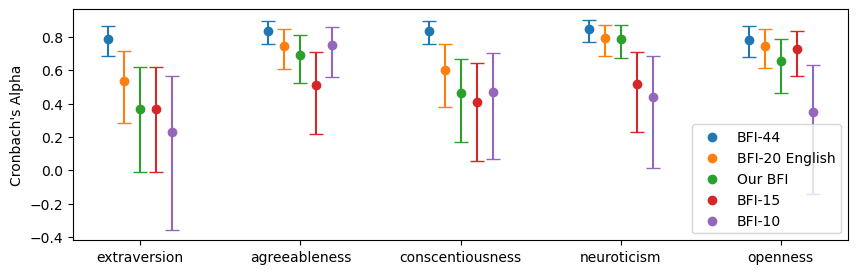

In [129]:
plt.rcParams["figure.figsize"] = (10,3)
x_values = np.arange(5)
x_labels = ['extraversion', 'agreeableness', 'conscentiousness', 'neuroticism', 'openness']
dot_alpha=1
bar_alpha=1

shift = 0.1

#print('BFI')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values - 2*shift, y_values, label='BFI-44', alpha=dot_alpha)
plt.errorbar(x_values - 2*shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 20 - English')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_ENGLISH_TWENTY_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values - shift, y_values, label='BFI-20 English', alpha=dot_alpha)
plt.errorbar(x_values - shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI - Ours')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], S)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values, y_values, label='Our BFI', alpha=dot_alpha)
plt.errorbar(x_values, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)


#print('BFI 15')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_FIFTEEN_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values + shift, y_values, label='BFI-15', alpha=dot_alpha)
plt.errorbar(x_values + shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 10')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_TEN_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values + 2*shift, y_values, label='BFI-10', alpha=dot_alpha)
plt.errorbar(x_values + 2*shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 20 - Norwegian')
#alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_NORWEGIAN_TWENTY_IDXS)
#y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
#plt.scatter(x_values, y_values, label='BFI-20 Norwegian', alpha=dot_alpha)
#plt.errorbar(x_values, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 20 - Porteguese')
#alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_PORTEGUESE_TWENTY_IDXS)
#y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
#plt.scatter(x_values, y_values, label='BFI-20 Porteguese', alpha=dot_alpha)
#plt.errorbar(x_values, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)



plt.xticks(x_values, x_labels)
plt.ylabel("Cronbach's Alpha")
plt.legend()

In [51]:
S

array([ 0,  2,  6,  7, 12, 13, 14, 15, 19, 20, 22, 24, 25, 27, 29, 31, 36,
       37, 38, 43])

In [49]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    factor_result = efa.efa(x=X[:, S], factors=5)

In [53]:
S

array([ 0,  2,  6,  7, 12, 13, 14, 15, 19, 20, 22, 24, 25, 27, 29, 31, 36,
       37, 38, 43])

In [52]:
np.round(factor_result['rotated'], 2)

array([[ 0.11,  0.77,  0.09, -0.06, -0.04],
       [-0.15,  0.54,  0.09,  0.25,  0.12],
       [ 0.22, -0.54,  0.04,  0.2 , -0.06],
       [-0.01,  0.81, -0.01,  0.09,  0.02],
       [ 0.03,  0.17, -0.08,  0.47,  0.14],
       [ 0.13, -0.17,  0.16, -0.65,  0.01],
       [ 0.11, -0.08,  0.19,  0.68,  0.06],
       [ 0.36,  0.09, -0.05, -0.52, -0.06],
       [ 0.11,  0.11,  0.02,  0.22,  0.49],
       [ 0.1 ,  0.11,  0.15, -0.01, -0.59],
       [-0.05, -0.1 ,  0.24, -0.02,  0.53],
       [ 0.06,  0.1 ,  0.  ,  0.04,  0.67],
       [ 0.51, -0.03,  0.01,  0.12, -0.36],
       [-0.57,  0.02,  0.02,  0.05,  0.09],
       [ 0.64, -0.06, -0.13,  0.06, -0.07],
       [ 0.78,  0.02, -0.02, -0.12,  0.09],
       [ 0.05,  0.09,  0.57, -0.06,  0.17],
       [-0.01,  0.09,  0.68,  0.03, -0.09],
       [-0.11,  0.02,  0.77,  0.01,  0.  ],
       [ 0.04, -0.15,  0.51,  0.09, -0.02]])